# MIDAS Summer Internship 2021 Task 2
Objective: Dataset 1(https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) Preprocessing.

Input taken: Images as .png files

Output: A .csv file, 28*28 images flattened alongwith corresponding labels.

In [1]:
%%bash
ls trainPart1 #To check whether we can see the dataset.

train


In [2]:
import numpy as np #For fast computations
import pandas as pd #For data manipulation
import cv2 #For resizing
import os #For importing dataset

## 1. Plot an image to have a look.

float32
(900, 1200, 3)


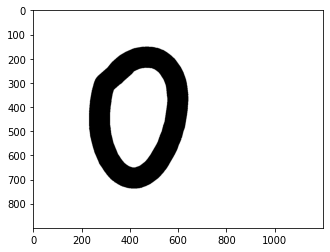

In [3]:
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('trainPart1/train/Sample001/img001-001.png')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

The image has a resolution too high. Also, 3 channels are not really needed.

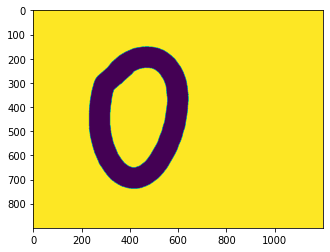

In [5]:
pyplot.imshow(data[:,:,0])

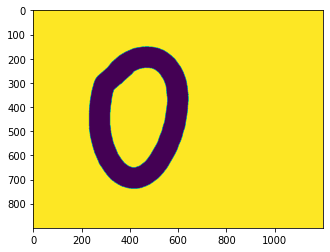

In [6]:
pyplot.imshow(data[:,:,1])

The channels look the same to me! 

In [8]:
new_data=data[:,:,0]+data[:,:,1]+data[:,:,2] #Add data from all channels.
new_data=new_data/3

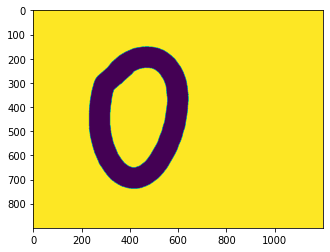

In [9]:
pyplot.imshow(new_data)

The above looks the same as the images before. But it also has some information from all channels. Hence, we'll do this when making the final dataset.

In [10]:
count=0 #Count the number of '1's in the image.
for i in new_data:
    for j in i:
        count+=j

In [11]:
dim=new_data.shape[0]*new_data.shape[1] #The total number of data points.

In [12]:
count/dim #Probablity for an entry to be a '1'. 

0.8940333333333333

In [13]:
new_data[700,400] #Since we can visually see that 700,400 has to be a '0', this confirms it.

0.0

## 2. Get the bounding box if the character.

In [14]:
def get_fine_bounds(data,
                    coordinate_1,
                    coordinate_2,
                    point_is_visited = [],
                    bound={},
                    points_to_travel=[]):
#Given a point, look for other neighbouring(data points above, below, to the right and to the left) points 
# and update bounds.
'''
Input:
    1. Data: The input image
    2. coordinate_1,coordinate_2: Coordinates of a point which is a '0'. 
        That is, a point that is a part of the character.
    3. point_is_visited: A 2D array to keep track of points which we have visited. 
        We should not revisit points as that will never terminate and no new information is gained.
    4. Bound: A dictionary containing the upper, lower, left and right bounds of the character.
    5. points_to_travel: A stack of point that were neighbours of some point we visited and 
        are themselves not yet visited.

Output: Bound
'''
    point_is_visited = [[0 for i in range(data.shape[1])] for j in range(data.shape[0])] #Initialize a zero array.
    bound={'left':2000,'right':0,'up':1000,'down':0} #Initialize bounds
    points_to_travel.append([coordinate_1,coordinate_2])

    while(points_to_travel): #While there are points we havent visited
        coordinate_1, coordinate_2= points_to_travel.pop()
        point_is_visited[coordinate_1][coordinate_2]=1 #Mark that we have visited this point.
        
        neighbours=[[coordinate_1+1,coordinate_2],
                    [coordinate_1-1,coordinate_2],
                    [coordinate_1,coordinate_2+1],
                    [coordinate_1,coordinate_2-1]]
        for point in neighbours: #Check for neighbours
            coordinate_1, coordinate_2= point
            if coordinate_1 < data.shape[0] and coordinate_2 < data.shape[1]: #Neighbours are legally valid points.
                if data[coordinate_1,coordinate_2]==0.0 and point_is_visited[coordinate_1][coordinate_2]==0:
                #if (the point is a part of the character) AND (the point is not visited yet)
                    bound['left']=min(coordinate_2,bound['left'])
                    bound['right']=max(coordinate_2,bound['right'])
                    bound['up']=min(coordinate_1,bound['up'])
                    bound['down']=max(coordinate_1,bound['down'])
                    points_to_travel.append([coordinate_1,coordinate_2]) #Visit, looking for other neighbours.
    return bound

In [15]:
def get_bounds(data):
#Find a point that is a part of the character and pass the point to the function above.
'''
Input: Data: The input image

Passes the point's coordinates to the above function.
'''
    padding=int((data.shape[1]-data.shape[0])/2)

    #Search starting from point (padding,0) diagonally upwards.
    for i in range(padding+10,data.shape[0]-10): # +-10 as it is unlikely that the character is at the boundary of img
        if data[i,padding+i]==0.0:
            return get_fine_bounds(data,i,padding+i)
  
  #Search starting from point (padding,data.shape[0]) diagonally downwards.
    for i in range(padding+10,data.shape[0]-10):
        if data[data.shape[0]-i,padding+i]==0.0:
            return get_fine_bounds(data,data.shape[0]-i,padding+i)
  
  #Search along the line that divides the picture into two halves horizontally.
    for i in range(padding+10,data.shape[0]-10):
        if data[int(data.shape[0]/2),i]==0.0:
            return get_fine_bounds(data,int(data.shape[0]/2),i)
  
  #Search along the line that divides the picture into two halves vertically.
    for i in range(padding+10,data.shape[0]-10):
        if data[i,int(data.shape[1]/2)]==0.0:
            return get_fine_bounds(data,i,int(data.shape[1]/2))

  #finally, fall back to the naive method. Check every point in every column and every row until we find a point.
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j]==0.0:
                return get_fine_bounds(data,i,j)


I could have also used binary search vertically and horizontally for the bound.
What I have done can be seen as a binary search in angles.

Let us now check whether our function is working correctly.

In [16]:
data = image.imread('trainPart1/train/Sample001/img001-011.png')
data=data[:,:,0]+data[:,:,1]+data[:,:,2]
data=data/3
bound_try=get_bounds(data)
print(bound_try)

{'left': 279, 'right': 486, 'up': 365, 'down': 570}


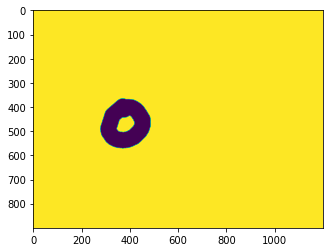

In [18]:
data = image.imread('trainPart1/train/Sample001/img001-011.png')
data=data[:,:,0]+data[:,:,1]+data[:,:,2]
data=data/3
pyplot.imshow(data)

The bound seems to be good. Let us plot and see.

{'left': 279, 'right': 486, 'up': 365, 'down': 570}


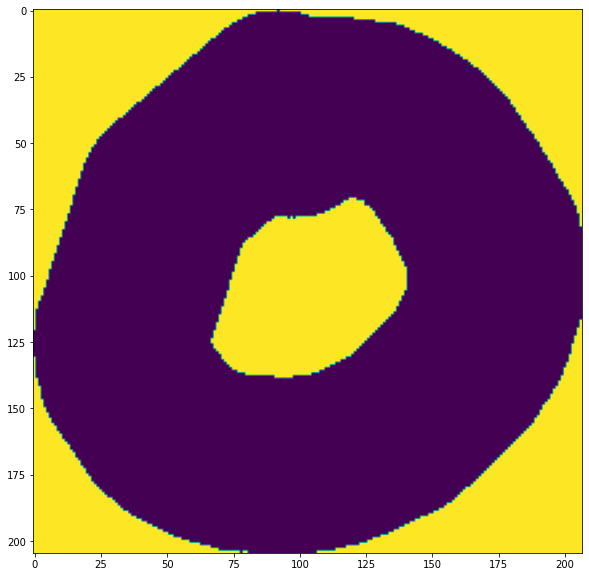

In [19]:
bound_try=get_bounds(data)
print(bound_try)
data=data[bound_try['up']:bound_try['down'],bound_try['left']:bound_try['right']]
pyplot.figure(figsize=(12, 10))
pyplot.imshow(data)

In [17]:
artoplot=[]
for img in os.listdir('trainPart1/train/Sample001'):
    data = image.imread('trainPart1/train/Sample001'+'/'+img)
    data=data[:,:,0]+data[:,:,1]+data[:,:,2]
    data=data/3
    bound_try=get_bounds(data)
    artoplot.append(data[bound_try['up']:bound_try['down'],bound_try['left']:bound_try['right']])

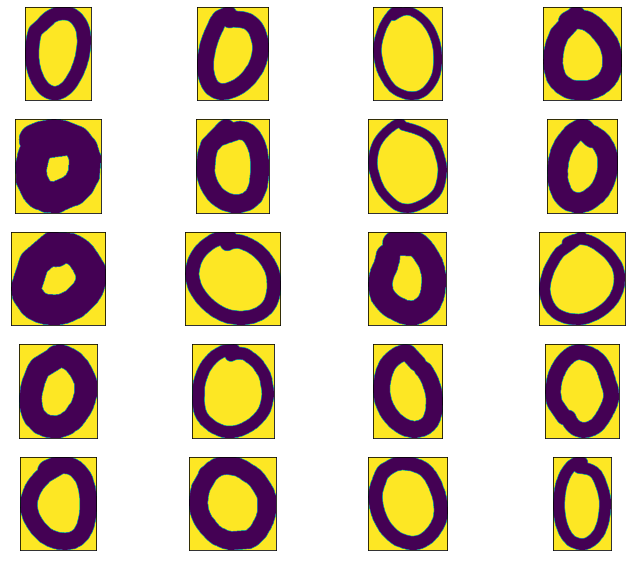

In [20]:
pyplot.figure(figsize=(12, 10))
for i in range(20):
    pyplot.subplot(5, 4, i+1)
    pyplot.grid(False)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.imshow(artoplot[i])

Works like a charm!

## 3. Pad, downsample and augment image.

In [25]:
def pad_data(data,horiz_center,verti_center,length_to_implement):
'''
Input: 
    1. data: The input image.
    2. horiz_center,verti_center: coordinates of the center of the image.
    3. length_to_implement: Length of the square containing the character.
Output: The part of input that has out character.
'''
#From the center, we make sure that the dimensions are valid. That is, we pad the input image if the part of data we
# intend to take is invalid(Since we cannot take, for example, 902th row if there are 900 rows.)
    stuff_to_insert=1 #While padding, insert this value
    length_to_implement_by_2=int(length_to_implement/2)+1
    
    left_bound = horiz_center - length_to_implement_by_2
    if left_bound < 0:
        data=np.pad(data, ((0,0),(-left_bound,0)), mode='constant', constant_values=stuff_to_insert)
        left_bound=0
    
    right_bound = horiz_center + length_to_implement_by_2
    if right_bound  - data.shape[1]> 0:
        data=np.pad(data, ((0,0),(0,right_bound-data.shape[1])), mode='constant', constant_values=stuff_to_insert)
        
    up_bound = verti_center - length_to_implement_by_2
    if up_bound < 0:
        data=np.pad(data, ((-up_bound,0),(0,0)), mode='constant', constant_values=stuff_to_insert)
        up_bound=0
    
    down_bound = verti_center + length_to_implement_by_2
    if down_bound - data.shape[0] > 0:
        data=np.pad(data, ((0,down_bound-data.shape[0]),(0,0)), mode='constant', constant_values=stuff_to_insert)

    return data[up_bound:down_bound,left_bound:right_bound]

In [26]:
def center_and_downsample_image(data):
#Centers and downsamples input image. Also flattens to store as a row.
'''
Input: data: The input image.
Output: temparray: Input image as a row, so that it can be stored easily.
'''
    result=get_bounds(data)
    width_req, height_req = result['right'] - result['left'], result['down'] - result['up'] #Dimensions of exact bound
    horiz_center, verti_center = int(result['left']+width_req/2), int(result['up']+height_req/2)
    
    #The padding we want AROUND our image.
    hori_shift=0.1*width_req
    verti_shift=0.1*height_req

    length_to_implement=max(width_req+2*hori_shift,height_req+2*verti_shift) #The dimension of our square window.
    data=pad_data(data,horiz_center,verti_center,length_to_implement) #Pad data appropriately.

    res = cv2.resize(data,
                    dsize=(28,28),
                    interpolation=cv2.INTER_LINEAR) #Resize the image to our needs.
    temparray=np.asarray(res)
    #The below are done to keep the data similar to MNIST.
    temparray=1-temparray
    temparray=temparray*255
    temparray=temparray.astype(int)
    temparray=np.resize(temparray,(1,28*28))
    return temparray

In [27]:
artoplot=[]
for img in os.listdir('trainPart1/train/Sample001'):
    data = image.imread('trainPart1/train/Sample001'+'/'+img)
    data=data[:,:,0]+data[:,:,1]+data[:,:,2]
    data=data/3
    finalarr=center_and_downsample_image(data)
    artoplot.append(finalarr)

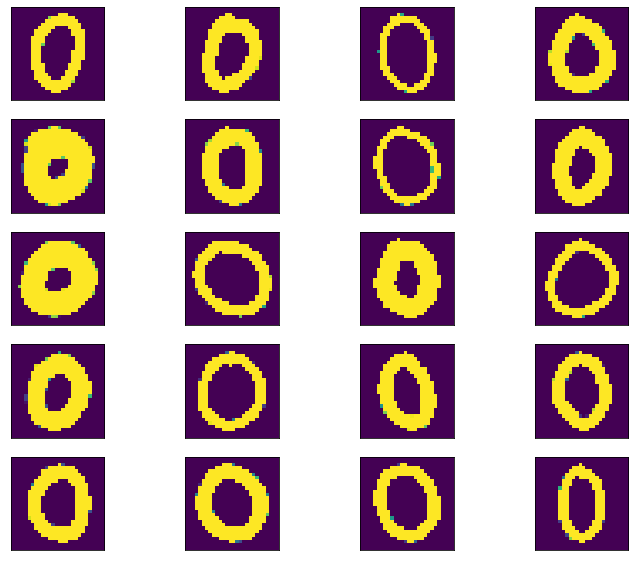

In [28]:
pyplot.figure(figsize=(12, 10))
for i in range(20):
    pyplot.subplot(5, 4, i+1)
    pyplot.grid(False)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.imshow(artoplot[i].reshape(28,28))

## 4. Store in a csv file.

In [23]:
#Let us initialize the dataframe in which we will store our result
width_req, height_req=[28,28]
dataframe={'label':[]}
for i in range(1,width_req*height_req+1):
    dataframe['pixel'+str(i)]=[]
df = pd.DataFrame(dataframe)
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784


In [29]:
#This is used for labelling image in our csv file. Maps folder to characters in the folder.
dirtochar={
 'Sample001': '0',
 'Sample002': '1',
 'Sample003': '2',
 'Sample004': '3',
 'Sample005': '4',
 'Sample006': '5',
 'Sample007': '6',
 'Sample008': '7',
 'Sample009': '8',
 'Sample010': '9',
 'Sample011': 'A',
 'Sample012': 'B',
 'Sample013': 'C',
 'Sample014': 'D',
 'Sample015': 'E',
 'Sample016': 'F',
 'Sample017': 'G',
 'Sample018': 'H',
 'Sample019': 'I',
 'Sample020': 'J',
 'Sample021': 'K',
 'Sample022': 'L',
 'Sample023': 'M',
 'Sample024': 'N',
 'Sample025': 'O',
 'Sample026': 'P',
 'Sample027': 'Q',
 'Sample028': 'R',
 'Sample029': 'S',
 'Sample030': 'T',
 'Sample031': 'U',
 'Sample032': 'V',
 'Sample033': 'W',
 'Sample034': 'X',
 'Sample035': 'Y',
 'Sample036': 'Z',
 'Sample037': 'a',
 'Sample038': 'b',
 'Sample039': 'c',
 'Sample040': 'd',
 'Sample041': 'e',
 'Sample042': 'f',
 'Sample043': 'g',
 'Sample044': 'h',
 'Sample045': 'i',
 'Sample046': 'j',
 'Sample047': 'k',
 'Sample048': 'l',
 'Sample049': 'm',
 'Sample050': 'n',
 'Sample051': 'o',
 'Sample052': 'p',
 'Sample053': 'q',
 'Sample054': 'r',
 'Sample055': 's',
 'Sample056': 't',
 'Sample057': 'u',
 'Sample058': 'v',
 'Sample059': 'w',
 'Sample060': 'x',
 'Sample061': 'y',
 'Sample062': 'z'
 }

In [30]:
for sample in os.listdir('trainPart1/train'): #For every folder
    for img in os.listdir('trainPart1/train/'+sample): #For every image
        data = image.imread('trainPart1/train/'+sample+'/'+img)
        data=data[:,:,0]+data[:,:,1]+data[:,:,2]
        data=data/3
        finalarr=center_and_downsample_image(data) #Row to be added in our dataset
        finalarr=finalarr.tolist()
        finalarr=finalarr[0]
        finalarr.insert(0,dirtochar[sample]) #insert label in the row.
        df.loc[len(df.index)]=finalarr #Add the row to the dataset
    print('Completed with '+sample+'/Sample062') #Notify of progress

Completed with Sample001/Sample062
Completed with Sample002/Sample062
Completed with Sample003/Sample062
Completed with Sample004/Sample062
Completed with Sample005/Sample062
Completed with Sample006/Sample062
Completed with Sample007/Sample062
Completed with Sample008/Sample062
Completed with Sample009/Sample062
Completed with Sample010/Sample062
Completed with Sample011/Sample062
Completed with Sample012/Sample062
Completed with Sample013/Sample062
Completed with Sample014/Sample062
Completed with Sample015/Sample062
Completed with Sample016/Sample062
Completed with Sample017/Sample062
Completed with Sample018/Sample062
Completed with Sample019/Sample062
Completed with Sample020/Sample062
Completed with Sample021/Sample062
Completed with Sample022/Sample062
Completed with Sample023/Sample062
Completed with Sample024/Sample062
Completed with Sample025/Sample062
Completed with Sample026/Sample062
Completed with Sample027/Sample062
Completed with Sample028/Sample062
Completed with Sampl

In [31]:
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2476,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2477,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2478,z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df.to_csv('preprocessed_final.csv', index = False) #Store dataframe as .csv file.